This script contains an example of MESMER-M-TP. The steps for working with MESMER-M-TP are the following
i. 

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
import matplotlib.pyplot as plt

In [3]:
import pathlib

import joblib
import numpy as np
import pytest
import xarray as xr

import mesmer

## Functions 

In [4]:
# functionalities 
def load_training_data(
    fN_hist_ann, fN_proj_ann, fN_hist_mon, fN_proj_mon, REFERENCE_PERIOD, THRESHOLD_LAND
    ):
    tas_ann = xr.open_mfdataset(
        [fN_hist_ann, fN_proj_ann],
        combine="by_coords",
        use_cftime=True,
        combine_attrs="override",
        data_vars="minimal",
        compat="override",
        coords="minimal",
        drop_variables=["height", "file_qf"],
    ).load()
    
    # data preprocessing
    # create global mean tas anomlies timeseries
    tas_ann = mesmer.grid.wrap_to_180(tas_ann)
    # convert the 0..360 grid to a -180..180 grid to be consistent with legacy code

    ref = tas_ann.sel(time=REFERENCE_PERIOD).mean("time", keep_attrs=True)
    tas_ann = tas_ann - ref
    tas_globmean = mesmer.weighted.global_mean(tas_ann)

    # create local gridded tas data
    def mask_and_stack(ds, threshold_land):
        ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
        ds = mesmer.mask.mask_antarctica(ds)
        ds = mesmer.grid.stack_lat_lon(ds)
        return ds

    tas_stacked_ann = mask_and_stack(tas_ann, threshold_land=THRESHOLD_LAND)
    
    tas_mon = xr.open_mfdataset(
        [fN_hist_mon, fN_proj_mon],
        combine="by_coords",
        use_cftime=True,
        combine_attrs="override",
        data_vars="minimal",
        compat="override",
        coords="minimal",
        drop_variables=["height", "file_qf"],
    ).load()
    
    # data preprocessing
    # create global mean tas anomlies timeseries
    tas_mon = mesmer.grid.wrap_to_180(tas_mon)
    # convert the 0..360 grid to a -180..180 grid to be consistent with legacy code

    ref = tas_mon.sel(time=REFERENCE_PERIOD).mean("time", keep_attrs=True)
    tas_mon = tas_mon - ref

    # create local gridded tas data
    def mask_and_stack(ds, threshold_land):
        ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
        ds = mesmer.mask.mask_antarctica(ds)
        ds = mesmer.grid.stack_lat_lon(ds)
        return ds

    tas_stacked_mon = mask_and_stack(tas_mon, threshold_land=THRESHOLD_LAND)
        
    
    return(tas_stacked_ann, tas_stacked_mon, tas_globmean)


## Config

In [5]:
# define config values
THRESHOLD_LAND = 1 / 3

REFERENCE_PERIOD = slice("1850", "1900")

HIST_PERIOD = slice("1850", "2014")
PROJ_PERIOD = slice("2015", "2100")

LOCALISATION_RADII = range(1750, 2001, 250)

esm = "IPSL-CM6A-LR"
scenario = 'ssp585'
run_id_training = 'r1i1p1f1'
test_cmip_generation = 6

# define paths and load data
CODE_PATH = pathlib.Path('/home/scsarah/mesmer')
TEST_DATA_PATH = CODE_PATH / 'tests' / 'test-data'
TEST_PATH = TEST_DATA_PATH / "output" / "tas" / "one_scen_one_ens"

cmip_data_path = (
    TEST_DATA_PATH / "calibrate-coarse-grid" / f"cmip{test_cmip_generation}-ng"
)


path_tas_ann = cmip_data_path / "tas" / "ann" / "g025"
fN_hist_ann = path_tas_ann / f"tas_ann_{esm}_historical_{run_id_training}_g025.nc"
fN_proj_ann = path_tas_ann / f"tas_ann_{esm}_{scenario}_{run_id_training}_g025.nc"
path_tas_mon = cmip_data_path / "tas" / "mon" / "g025"
fN_hist_mon = path_tas_mon / f"tas_mon_{esm}_historical_{run_id_training}_g025.nc"
fN_proj_mon = path_tas_mon / f"tas_mon_{esm}_{scenario}_{run_id_training}_g025.nc"

## MAIN

### Loading data

In [6]:
tas_stacked_ann, tas_stacked_mon, tas_globmean = load_training_data(fN_hist_ann, fN_proj_ann, fN_hist_mon, fN_proj_mon, REFERENCE_PERIOD, THRESHOLD_LAND)

### Calibrating GMT parameters

In [7]:
# trend
tas_globmean_lowess = mesmer.stats.lowess(
    tas_globmean, "time", n_steps=50, use_coords=False
)
tas_lowess_residuals = tas_globmean - tas_globmean_lowess

volcanic_params = mesmer.volc.fit_volcanic_influence(
    tas_lowess_residuals.tas, hist_period=HIST_PERIOD, dim="time"
)

tas_globmean_volc = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_lowess, volcanic_params, hist_period=HIST_PERIOD, dim="time"
)

In [8]:
# variability 
def _split_hist_proj(
        obj, dim="time", hist_period=HIST_PERIOD, proj_period=PROJ_PERIOD
    ):
        hist = obj.sel({dim: hist_period})
        proj = obj.sel({dim: proj_period})

        return hist, proj

tas_hist_globmean_smooth_volc, tas_proj_smooth = _split_hist_proj(tas_globmean_volc)

tas_hist_resid_novolc = tas_globmean - tas_hist_globmean_smooth_volc
tas_proj_resid = tas_globmean - tas_proj_smooth

data = (tas_hist_resid_novolc.tas, tas_proj_resid.tas)

ar_order = mesmer.stats.select_ar_order_scen_ens(
    *data, dim="time", ens_dim="ens", maxlag=12, ic="bic"
)
global_ar_params = mesmer.stats.fit_auto_regression_scen_ens(
    *data, dim="time", ens_dim="ens", lags=ar_order
)

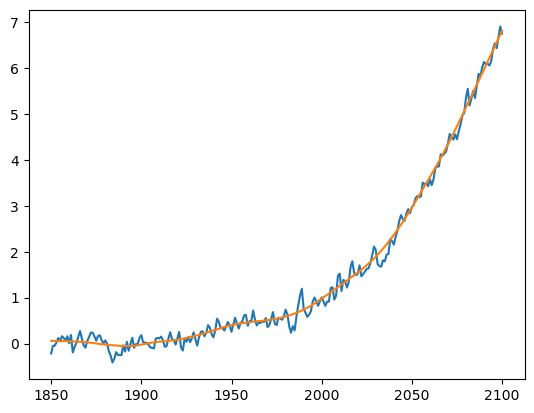

In [9]:
# visual inspection: 
plt.figure()
plt.plot(np.arange(1850,2101), tas_globmean['tas'])
plt.plot(np.arange(1850,2101), tas_globmean_lowess['tas'])
plt.show()


In [10]:
from mesmer.core.utils import upsample_yearly_data

tas_hist_globmean_smooth_volc_monthly = upsample_yearly_data(tas_hist_globmean_smooth_volc.tas, tas_stacked_mon.time[:165*12])
tas_hist_resid_novolc_monthly = upsample_yearly_data(tas_hist_resid_novolc.tas, tas_stacked_mon.time[:165*12])
tas_proj_smooth_monthly = upsample_yearly_data(tas_proj_smooth.tas, tas_stacked_mon.time[165*12:])
tas_proj_resid_monthly = upsample_yearly_data(tas_proj_resid.tas, tas_stacked_mon.time[165*12:])

predictors_split = {
    "tas_globmean": [tas_hist_globmean_smooth_volc_monthly.groupby('time.month'), tas_proj_smooth_monthly.groupby('time.month')],
    "tas_globmean_resid": [tas_hist_resid_novolc_monthly.groupby('time.month'), tas_proj_resid_monthly.groupby('time.month')],
}

### Calibrating monthly local forced response

In [11]:
from mesmer.core.utils import upsample_yearly_data

tas_hist_globmean_smooth_volc_monthly = upsample_yearly_data(tas_hist_globmean_smooth_volc.tas, tas_stacked_mon.time[:165*12])
tas_hist_resid_novolc_monthly = upsample_yearly_data(tas_hist_resid_novolc.tas, tas_stacked_mon.time[:165*12])
tas_proj_smooth_monthly = upsample_yearly_data(tas_proj_smooth.tas, tas_stacked_mon.time[165*12:])
tas_proj_resid_monthly = upsample_yearly_data(tas_proj_resid.tas, tas_stacked_mon.time[165*12:])

predictors_split = {
    "tas_globmean": [tas_hist_globmean_smooth_volc_monthly.groupby('time.month'), tas_proj_smooth_monthly.groupby('time.month')],
    "tas_globmean_resid": [tas_hist_resid_novolc_monthly.groupby('time.month'), tas_proj_resid_monthly.groupby('time.month')],
}

import collections 
predictors_mon = collections.defaultdict(dict)
for m in range(1,13):
   for key, value in predictors_split.items():
       predictors_mon[m][key] = xr.concat([v[m] for v in value], dim="time")

local_forced_response_mon_lr_list = []

for m in range(1,13):
    local_forced_response_mon_lr = mesmer.stats.LinearRegression()

    local_forced_response_mon_lr.fit(
        predictors=predictors_mon[m],
        target=tas_stacked_mon['tas'].groupby('time.month')[m],
        dim="time",  # switch to sample?
    )
    
    local_forced_response_mon_lr_list.append(local_forced_response_mon_lr)  
    
month = xr.Variable("month", np.arange(1, 13))
tas_mon_stacked_residuals = xr.merge([local_forced_response_mon_lr_list[m-1].residuals(predictors=predictors_mon[m], target=tas_stacked_mon['tas'].groupby('time.month')[m]
                                                                   ) for m in range(1,13)])['residuals']
tas_mon_stacked_fits = xr.merge([local_forced_response_mon_lr_list[m-1].predict(predictors=predictors_mon[m]).T for m in range(1,13)])['prediction']

In [12]:
# m = 1
# for j in np.random.randint(0,118,10):
#     print(j)
#     plt.figure()
#     plt.plot(tas_stacked_mon['tas'].groupby('time.month')[m][:,j])
#     plt.plot(tas_mon_stacked_fits.values[m-1::12, j])
#     plt.show()

### Calibrating monthly local variability

In [41]:
# PCA transform
params = mesmer.stats.fit_principal_components(tas_mon_stacked_fits, n_components = 118)
tas_mon_stacked_residuals_pca = mesmer.stats.transform_principal_components(tas_mon_stacked_fits, params = params)
original = mesmer.stats.inverse_transform_principal_components(tas_mon_stacked_residuals_pca, params = params)
np.allclose(tas_mon_stacked_fits, original)

True

In [ ]:
# ToDo: adjust Yeo Johnson transform to allow for 'component' dimension instead of 'gridcell' dimension
# for now: quick and dirty fix: renaming component --> grid-cell dimenisons 
tas_mon_stacked_residuals_pca = tas_mon_stacked_residuals_pca.rename({'component': 'gridcell'})
# non-stationary Yeo Johnson transform
tas_y_data = tas_mon_stacked_fits.groupby('time.year').mean()
tas_y_data = tas_y_data.rename({'year': 'time'})
# train power transformer
pt_coefficients = mesmer.stats.fit_yeo_johnson_transform(tas_y_data, tas_mon_stacked_residuals_pca)
transformed_mon_residuals = mesmer.stats.yeo_johnson_transform(tas_y_data, tas_mon_stacked_residuals_pca, pt_coefficients)

In [ ]:
# This is not yet in xarray format... 
# fit cyclo-stationary AR(1) process
AR1_fit = mesmer.stats.fit_auto_regression_monthly(
    transformed_mon_residuals.transformed, time_dim="time"
)

from numpy.random import multivariate_normal

covs = [np.cov(AR1_fit.residuals[:, m::12].values) for m in range(12)] 
covs_adj = [mesmer.stats.adjust_covariance_ar1(covs[m], AR1_fit['slope'].isel(month = m)) for m in range(12)]

/home/scsarah/mesmer/mesmer/stats/_localized_covariance.py:72: RuntimeWarning: invalid value encountered in sqrt
  reduction_factor = np.sqrt(1 - ar_coefs**2)
